# Chaotic model divergence: an ensemble of Lorenz 96 models using basic model interface (BMI)
The Lorenz 96 model is a model often used to demonstrate chaotic behavior and it is the de-facto standard benchmark model used in the field of data assimilation to test data assimilation methods. In this notebook I present how to easily interact with an implementation of the Lorenz 96 model through the Basic Model Interface (BMI). I show to run a complete ensemble of model-instances that illustrates the chaotic nature of the model.

## the Lorenz 96 model
The Lorenz 96 model is a dynamical sytem for $i=1,...,N$ defined by
\begin{equation}
\frac{dx_{i}}{dt}=\left(x_{i+1} - x_{i-2}\right)x_{i-1} - x_{i} + F
\end{equation}
where i is cyclical, ie. $x_{0}=x_{N}$ and $x_{-1} = x_{N-1}$. $F$ is an external force acting on the system. A value of $F=8$ is known to create chaotic bahavior and is often used. The dimension $N$ can be freely chosen and is typical $40$, but for testing very high dimension systems, higher values can be used. The Lorenz 96 model is a typical chaotic model where, although, the model is deterministic, slight variations in the input state will over time result in complete different states.

## Numerical implementation of the Lorenz 96 model
A fourth order Runga Kutta scheme is used to implement the Lorenz 96 model. Writing the entire state-vector as $\vec{x}$ and using $f\left(\vec{x}\right)$ as the right hand side of the model, ie:
\begin{eqnarray}
f\left(x_{i}\right) = \left(x_{i+1} - x_{i-2}\right)x_{i-1} - x_{i} + F
\\
f\left(\vec{x}\right) = \left\{f\left(x_{1}\right),...,f\left(x_{N}\right)\right\}
\end{eqnarray}
the implementation is given by:
\begin{eqnarray}
\vec{k}_{1}=f\left(\vec{x}\left(t\right)\right)
\\
\vec{k}_{2}=f\left(\vec{x}\left(t\right) + \frac{1}{2}\vec{k}_{1}\Delta t\right)
\\
\vec{k}_{3}=f\left(\vec{x}\left(t\right) + \frac{1}{2}\vec{k}_{2}\Delta t\right)
\\
\vec{k}_{4}=f\left(\vec{x}\left(t\right) + \vec{k}_{3}\Delta t\right)
\end{eqnarray}
and finally
\begin{equation}
\vec{x}\left(t + \Delta t\right) = \vec{x}\left(t\right) + \frac{1}{6}\left(\vec{k}_{1} + 2\vec{k}_{2} + 2 \vec{k}_{3} + \vec{k}_{4}\right)
\end{equation}

## The Basic Model Interface (BMI)
The basic model interface allows communicating with models in a generic fashion. It requires a few standard methods to be available such as 'initialize()' and 'update()'. Methods that are not relevant for the model need still be implemented, but can simply raise a one line exception. See [ref] for more information. Implementing the BMI allows easy interaction with the model. The cells below initiate one instance of the model. For reasons that will become clear we will call this instance "truthModel".

BMI models are typically initialized with a settings-file. This is overkill here, but for completeness, we generate the settings-file first and than pass it to the model.

In [1]:
#required libraries and settings
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import io

import BMILorenz

In [2]:
#create an instance of the BMILorenz class
truthModel = BMILorenz.BMILorenz ()

#initialize the model
J = 40 #dimension of Lorenz Model

#make a starting state vector
commonStartState = np.zeros(J)
commonStartState[19]=0.01

# Define settings data
settings = {'J': J,
            'F': 8.0,
            'startTime': 0.0,
            'endTime': 20.0,
            'dt':1e-3,
            'startState': commonStartState}

# Write YAML file
with io.open('settings.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(settings, outfile, default_flow_style=False, allow_unicode=True)

#initialize model
truthModel.initialize('settings.yaml')

### Running the model
The model is now all set to run. We need to choose which variables to save every timestep. In the case of the Lorenz model we choose the 5th element of the state-vector, yet this is arbitrary. 

The model us run for one timestep by calling `truthModel.update()`. We check if the model time is greater than the end time by using `truthModel.get_current_time()` and `truthModel.get_end_time()` 

In [3]:
output = pd.DataFrame(columns = ['truth'])


while truthModel.get_current_time() < truthModel.get_end_time():
    truthModel.update()
    output.loc[truthModel.get_current_time()] = truthModel.get_value_at_indices('state',5)
    

Let's plot the output of the model

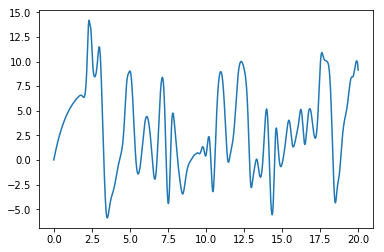

In [4]:
plt.plot(output)
plt.show()

## creating an ensemble of models
An ensemble of model instances can be easily created by making an array of model objects. Below I slightly change the starting state of the ensemble members by using the `model.set_value_at_indices()` function.

In [5]:
N = 25 #numeber of ensemble members

#start with  an empty ensemble
ensemble = []

for n in range (N):
    #add an ensemble methods
    ensemble.append(BMILorenz.BMILorenz ())
    ensemble[n].initialize('settings.yaml')
    ensemble[n].set_value_at_indices('state',5,ensemble[n].get_value_at_indices('state',5) + np.random.randn(1)*0.01)
    
    #also add a column to the output dataframe to store the output
    output['ensemble' + str(n)]= np.nan
    
    

In [6]:
#run the Ensemble. We will use the time of the first ensemble member to keep time, assuming that all
#models use the same time steps.

while ensemble[0].get_current_time()<ensemble[0].get_end_time():

    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        output.at[ensemble[n].get_current_time(),'ensemble' + str(n)] = ensemble[n].get_value_at_indices('state',5)


### output of the ensemble
I plot the output of all ensemble members in black and the truth in red

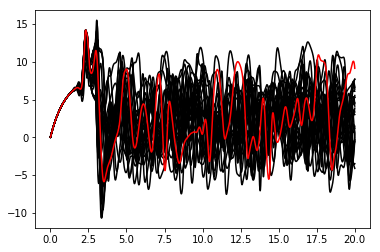

In [7]:
plt.plot(output.loc[:,'ensemble0':],'k')
plt.plot(output.loc[:,'truth'],'r')
plt.show()

It shows that after a certain moment in time the ensemble starts diverging from the truth: the little variations on the starting conditions are enough to trigger this behavior. Zooming in on the point where the divergence starts shows this behavior

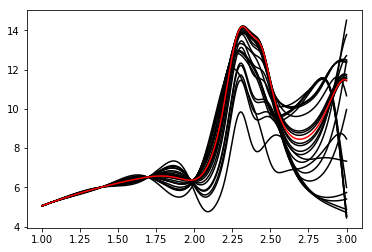

In [8]:
plt.plot(output.loc[1:3,'ensemble0':],'k')
plt.plot(output.loc[1:3,'truth'],'r')
plt.show()